In [15]:
#! rm -rf *

In [16]:
! wget "https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/8089/44321/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1595561725&Signature=I7SRMS4Uxa7MlG2hFUXTjMHDOE%2FfJTZZEMhcPQMbdOiPIgZg0CQwMB7sAt%2BoLJSryIWRZa3Dgiab9cvUjZgK%2BiDLhz%2BYvblj7m10c6v%2FFpJJKrxgEdE91KmX8XdYbnvOlrmvdshsngdx7VvbdxwJ9epsXUFF%2Fo0%2BIgrxuzVh39UbRw9NBEuC7Vk0809%2BcUXoBKYPEKpHDuqnxgA5sjq%2BeIkxbnII0bYNCYLVJuO7BWQohNLB23beqrmzX%2FJjX9ZdYS9LF68U2iyjEyI4HOS%2FlCgpVnlWEcEm83qP2tNvaKl0mqqzWawQaqMZqYbJHGWuxtUb64mocjLN%2FlkmHzbYXg%3D%3D&response-content-disposition=attachment%3B+filename%3Ddata-science-bowl-2018.zip" -O data-science-bowl-2018.zip

--2020-07-21 04:14:41--  https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/8089/44321/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1595561725&Signature=I7SRMS4Uxa7MlG2hFUXTjMHDOE%2FfJTZZEMhcPQMbdOiPIgZg0CQwMB7sAt%2BoLJSryIWRZa3Dgiab9cvUjZgK%2BiDLhz%2BYvblj7m10c6v%2FFpJJKrxgEdE91KmX8XdYbnvOlrmvdshsngdx7VvbdxwJ9epsXUFF%2Fo0%2BIgrxuzVh39UbRw9NBEuC7Vk0809%2BcUXoBKYPEKpHDuqnxgA5sjq%2BeIkxbnII0bYNCYLVJuO7BWQohNLB23beqrmzX%2FJjX9ZdYS9LF68U2iyjEyI4HOS%2FlCgpVnlWEcEm83qP2tNvaKl0mqqzWawQaqMZqYbJHGWuxtUb64mocjLN%2FlkmHzbYXg%3D%3D&response-content-disposition=attachment%3B+filename%3Ddata-science-bowl-2018.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.133.128, 108.177.15.128, 173.194.76.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.133.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375761663 (358M) [application/zip]
Saving to: ‘data-science-bowl-2018.

In [17]:
! unzip -qq data-science-bowl-2018.zip

In [1]:
## Imports
import os
import sys
import random
from datetime import datetime
import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard


## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

Using TensorFlow backend.


In [2]:
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=8, image_size=128):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()
        
    def __load__(self, id_name):
        ## Path
        image_path = os.path.join(self.path, id_name, "images", id_name) + ".png"
        mask_path = os.path.join(self.path, id_name, "masks/")
        all_masks = os.listdir(mask_path)
        
        ## Reading Image
        image = cv2.imread(image_path, 1)
        image = cv2.resize(image, (self.image_size, self.image_size))
        
        mask = np.zeros((self.image_size, self.image_size, 1))
        
        ## Reading Masks
        for name in all_masks:
            _mask_path = mask_path + name
            _mask_image = cv2.imread(_mask_path, -1)
            _mask_image = cv2.resize(_mask_image, (self.image_size, self.image_size)) #128x128
            _mask_image = np.expand_dims(_mask_image, axis=-1)
            mask = np.maximum(mask, _mask_image)
            
        ## Normalizaing 
        image = image/255.0
        mask = mask/255.0
        
        return image, mask
    
    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        
        image = []
        mask  = []
        
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)
            
        image = np.array(image)
        mask  = np.array(mask)
        
        return image, mask
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

In [3]:
! unzip -qq stage1_train.zip -d stage1_train
! unzip -qq stage1_test.zip -d stage1_test
! unzip -qq  stage1_solution.csv.zip
! unzip -qq stage1_train_labels.csv.zip
! unzip -qq stage2_sample_submission_final.csv.zip
! unzip -qq stage2_test_final.zip -d stage2_test_final
! rm -rf *.zip

unzip:  cannot find or open stage1_train.zip, stage1_train.zip.zip or stage1_train.zip.ZIP.


KeyboardInterrupt: ignored

In [4]:
image_size = 128
train_path = "stage1_train/"
epochs = 200
batch_size = 4

## Training Ids
train_ids = next(os.walk(train_path))[1]

## Validation Data Size
val_data_size = 10

valid_ids = train_ids[:val_data_size]
train_ids = train_ids[val_data_size:]

In [5]:
gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=image_size)
x, y = gen.__getitem__(0)
print(x.shape, y.shape)

(4, 128, 128, 3) (4, 128, 128, 1)


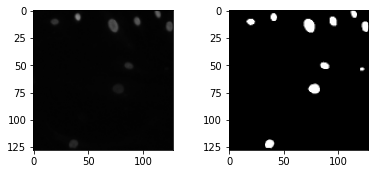

In [6]:
r = random.randint(0, len(x)-1)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[r], (image_size, image_size)), cmap="gray")

In [7]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [8]:
def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [9]:
model = UNet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 16)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

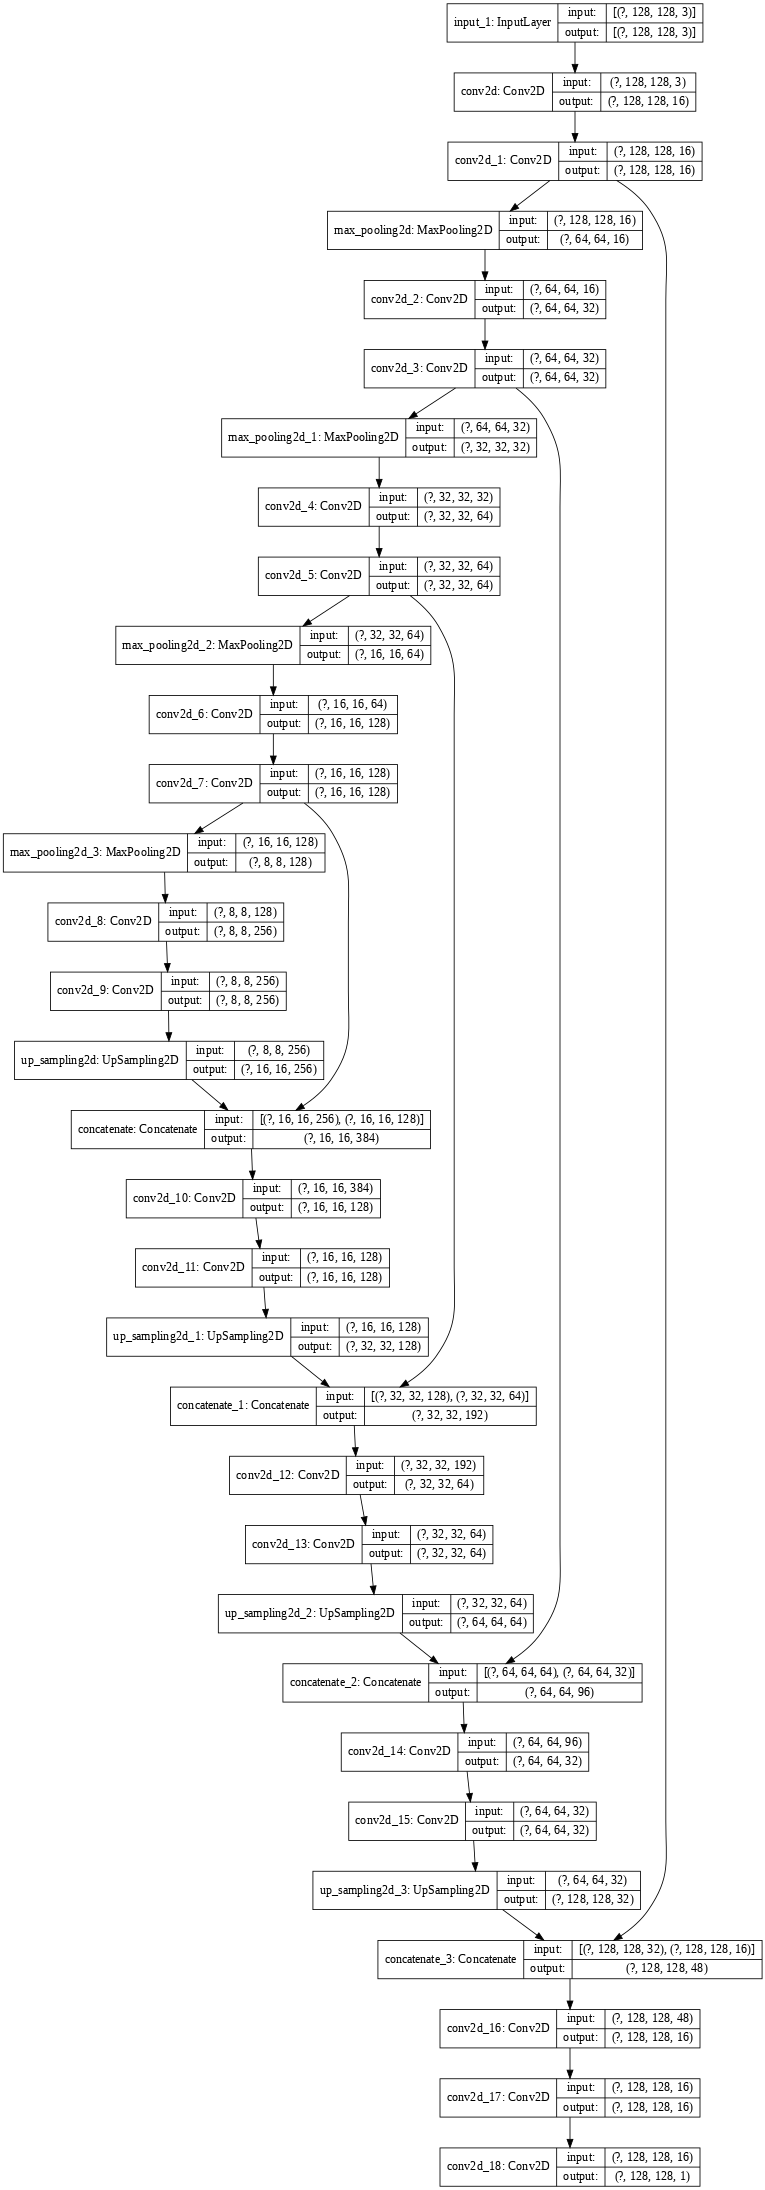

In [10]:
from tensorflow.keras.utils import  plot_model as pm  #plotting the model structure
pm(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True,dpi=60)

In [11]:
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size

# for storing logs into tensorboard
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

history = model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, 
                    epochs=epochs)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
165/165 [==============================] - 33s 197ms/step - loss: 0.4072 - acc: 0.8514 - val_loss: 0.2353 - val_acc: 0.8977
Epoch 2/20
165/165 [==============================] - 32s 197ms/step - loss: 0.1463 - acc: 0.9280 - val_loss: 0.1547 - val_acc: 0.9249
Epoch 3/20
165/165 [==============================] - 32s 195ms/step - loss: 0.1065 - acc: 0.9435 - val_loss: 0.1195 - val_acc: 0.9304
Epoch 4/20
165/165 [==============================] - 32s 195ms/step - loss: 0.0980 - acc: 0.9464 - val_loss: 0.1573 - val_acc: 0.9229
Epoch 5/20
165/165 [==============================] - 32s 194ms/step - loss: 0.0894 - acc: 0.9496 - val_loss: 0.1258 - val_acc: 0.9323
Epoch 6/20
165/165 [==============================] - 32s 196ms/step - loss: 0.0815 - acc: 0.9522 - val_loss: 0.1423 - val_acc: 0.9301
Epoch 7/20
165/165 [==============================] - 33s 197ms/step - loss: 0.0792 - acc: 0.9530 - val_loss: 0.10

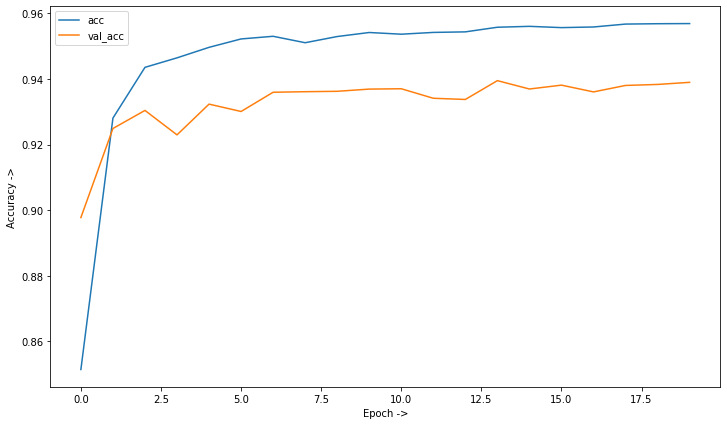

<Figure size 432x288 with 0 Axes>

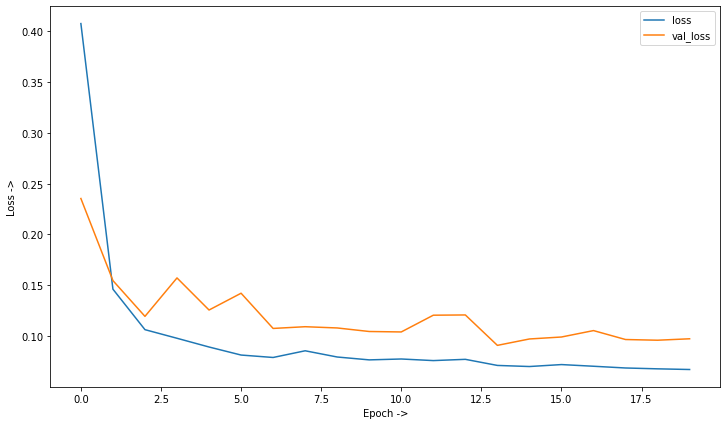

<Figure size 432x288 with 0 Axes>

In [12]:
plt.figure(figsize=(12,7))
legend_acc = []
for item in history.history.keys():
  if item.split('_')[-1:] == ['acc']:
    #print("Accuracy = ",item)
    legend_acc.append(item)
    plt.plot(history.history[item])
plt.ylabel('Accuracy ->')
plt.xlabel('Epoch ->')
plt.legend(legend_acc, loc='upper left')
plt.show()
plt.savefig('acc.png')

plt.figure(figsize=(12,7))
legend_acc = []
for item in history.history.keys():
  if item.split('_')[-1:] == ['loss']:
    #print("Accuracy = ",item)
    legend_acc.append(item)
    plt.plot(history.history[item])
plt.ylabel('Loss ->')
plt.xlabel('Epoch ->')
plt.legend(legend_acc, loc='upper right')
plt.show()
plt.savefig('loss.png')

In [16]:
## Save the Weights
model.save_weights("UNetW.h5")

## Dataset for prediction
x, y = valid_gen.__getitem__(1)
result = model.predict(x)

result = result > 0.5

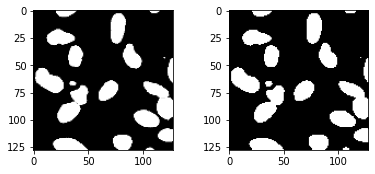

In [17]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")

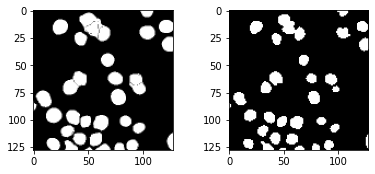

In [18]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[1]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[1]*255, (image_size, image_size)), cmap="gray")